# Matrix-vector products with Toeplitz and Circulant matrices

This notebook illustrates algoritmhs for computing the matrix-vector product for the cases in which the matrix is Toeplitz or Circulant.

#### References

* Jain, A. K. (1989), Fundamentals of Digital Image Processing, Prentice Hall, ISBN 978-0-13-336165-0.

* Horn, R. A. and C. R. Johnson, (1991), Topics in Matrix Analysis, Cambridge University Press, ISBN 978-0-521-46713-1.

* Chan, R. H. and X-Q Jin (2007), An introduction to iterative Toeplitz solvers, Philadelphia: Society for Industrial and Applied Mathematics, ISBN 978-0-898716-36-8. 

* Golub, G. H. and C. F. Van Loan, (2013), Matrix computations, 4th edition, Johns Hopkins University Press, ISBN 978-1-4214-0794-4.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, circulant, dft
from scipy.fft import fft, ifft, fft2, ifft2

### Circulant matrices

A $N \times N$ **circulant** matrix $\mathbf{C}$ is a particular Toeplitz matrix that can be defined in terms of its first column $\mathbf{c}_{0}$, as follows:

$$
\mathbf{C} = c_{00} \, \mathbf{I} + c_{10} \, \mathbf{D} + c_{20} \, \mathbf{D}^{2} + ... + c_{(N-1)0} \, \mathbf{D}^{N-1} \: ,
$$

where $\mathbf{I}$ is the identity matrix and $\mathbf{D}$ is the *downshift permutation matrix* (Golub and Van Loan, 2013, p. 220). For $N = 4$, the downshift permutation matrix is given by:

$$
\mathbf{D} = \begin{bmatrix}
0 & 0 & 0 & 1 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0
\end{bmatrix} \quad ,
$$

$$
\mathbf{D}^{2} = \begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix} \quad ,
$$

$$
\mathbf{D}^{3} = \begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
1 & 0 & 0 & 0
\end{bmatrix} \quad .
$$

In [5]:
x = np.arange(5)
print(x)

[0 1 2 3 4]


In [6]:
D = np.roll(np.identity(5), shift=1, axis=0)

In [7]:
print(D)

[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [8]:
print(np.dot(D, x))

[4. 0. 1. 2. 3.]


In [9]:
N = 5
#col_C = np.round(2*np.random.rand(N) - 1, decimals=2)
col_C = np.linspace(-1, 1, N)

In [10]:
C = circulant(col_C)

In [11]:
print(C)

[[-1.   1.   0.5  0.  -0.5]
 [-0.5 -1.   1.   0.5  0. ]
 [ 0.  -0.5 -1.   1.   0.5]
 [ 0.5  0.  -0.5 -1.   1. ]
 [ 1.   0.5  0.  -0.5 -1. ]]


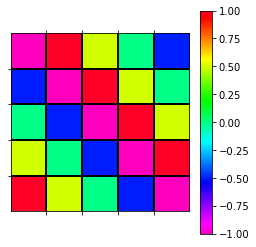

In [12]:
plt.close('all')
plt.matshow(C, vmin = -1, vmax = 1, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.yticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.grid(color='k', linewidth=2)
plt.show()

### Circulant matrices are diagonalized by the Fourier matrix

The eigenvalues of a [**circulant matrix**](https://en.wikipedia.org/wiki/Circulant_matrix) can be computed by using the 1D Discrete Fourier Transform (DFT).

Let's consider a $N \times 1$ data vector $\mathbf{d}$. The DFT of $\tilde{\mathbf{d}}$ can be computed as follows:

$$
\tilde{\mathbf{d}} = \mathbf{F}_{(N)} \mathbf{d} \: ,
$$

where $\mathbf{F}_{(N)}$ is $N \times N$ the [**DFT matrix**](https://en.wikipedia.org/wiki/DFT_matrix).

In [13]:
FN = dft(N, scale='sqrtn')

Here, we compute the [**DFT matrix**](https://en.wikipedia.org/wiki/DFT_matrix) $\mathbf{F}_{(N)}$ by using the scale $\sqrt{N}$, where $N$ is the number of data.

This scale makes the DFT matrix [**unitary**](https://en.wikipedia.org/wiki/Unitary_matrix), with inverse given by $\mathbf{F}_{(N)}^{-1} = \mathbf{F}_{(N)}^{H}$, where $\mathbf{F}_{(N)}^{H}$ is its [**conjugate transpose**](https://en.wikipedia.org/wiki/Conjugate_transpose).

In [14]:
np.allclose(np.dot(np.conjugate(FN).T, FN), np.identity(N))

True

Besides, it can be shown that $\mathbf{F}_{(N)}^{H} = \mathbf{F}_{(N)}^{\ast}$ (Golub and Van Loan, 2013), where $\mathbf{F}_{(N)}^{\ast}$ is the [**conjugate matrix**](http://mathworld.wolfram.com/ConjugateMatrix.html) of $\mathbf{F}_{(N)}$.

In [15]:
np.allclose(np.conjugate(FN).T, np.conjugate(FN))

True

In this case, the product $\mathbf{F}_{(N)}^{\ast}\mathbf{F}_{(N)} = \mathbf{F}_{(N)}\mathbf{F}_{(N)}^{\ast} = \mathbf{I}$

In [16]:
np.allclose(np.dot(np.conjugate(FN), FN), np.identity(N))

True

As a consequence, the Inverse Discrete Fourier Transform (IDFT) can be defined as follows:

$$
\mathbf{d} = \mathbf{F}_{(N)}^{\ast} \tilde{\mathbf{d}} \: .
$$

It can be shown that the DFT matrix $\mathbf{F}_{(N)}$ diagonalizes a circulant matrix $\mathbf{C}$. It means that the matrix $\mathbf{C}$ satisfies the following equation:

$$
\mathbf{C} = \mathbf{F}_{(N)}^{\ast}\boldsymbol{\Lambda}\mathbf{F}_{(N)} \: ,
$$

where $\boldsymbol{\Lambda}$ is a diagonal matrix containing the eigenvalues of $\mathbf{C}$.

By properly manipulating the equation above, we obtain:

$$
\begin{split}
\mathbf{C} &= \mathbf{F}_{(N)}^{\ast}\boldsymbol{\Lambda} \, \mathbf{F}_{(N)} \\
\mathbf{F}_{(N)} \mathbf{C} &= \boldsymbol{\Lambda} \, \mathbf{F}_{(N)} \\
\mathbf{F}_{(N)} \, \mathbf{C} \, \mathbf{u}_{0} &= \boldsymbol{\Lambda} \, \mathbf{F}_{(N)} \, \mathbf{u}_{0} \\
\mathbf{F}_{(N)} \, \mathbf{c}_{0} &= \boldsymbol{\Lambda} \, \frac{1}{\sqrt{N}}\mathbf{1}_{(N)} \\
\mathbf{F}_{(N)} \, \mathbf{c}_{0} &= \frac{1}{\sqrt{N}} \boldsymbol{\lambda}
\end{split} \quad ,
$$

where $\mathbf{u}_{0}$ is an $N \times 1$ vector with first element equal to $1$ and all the remaining elements equal to $0$, $\mathbf{c}_{0}$ is the first column of $\mathbf{C}$, $\mathbf{1}_{(N)}$ is an $N \times 1$ with all elements equal to 1 and $\boldsymbol{\lambda}$ is a vector representing the diagonal of $\boldsymbol{\Lambda}$ (the eigenvalues of $\mathbf{C}$ ).

This equation shows that the eigenvalues of $\mathbf{C}$ can be computed as the DFT of its first column.

In [17]:
# vector containing the eigenvalues of C
lambda_C = np.sqrt(N)*np.dot(FN, C[:,0])

In [18]:
# diagonal matrix containing the eigenvalues of C
Lambda_C = np.diag(lambda_C)

In [19]:
# alternative C
C2 = np.linalg.multi_dot([np.conjugate(FN), Lambda_C, FN]).real

In [20]:
# compare the original circulant matrix C and its alternative form
np.allclose(C, C2)

True

### Product of a Circulant matrix $\mathbf{C}$ and arbitrary vector $\mathbf{v}$

Let $\mathbf{v}$ be an arbitrary $N \times 1$ vector. The product of the circulant matrix $\mathbf{C}$ and vector $\mathbf{v}$ is given by:

$$
\begin{split}
\mathbf{C} \, \mathbf{v} 
&= \mathbf{F}_{(N)}^{\ast} \, \boldsymbol{\Lambda} \, 
\overbrace{\left( \mathbf{F}_{(N)} \, \mathbf{v} \right)}^{\text{DFT of } \mathbf{v}} \\
&= \mathbf{F}_{(N)}^{\ast} 
\underbrace{\left( \boldsymbol{\lambda} \circ \tilde{\mathbf{v}} \right)}_{\text{Hadamard product}}
\end{split} \quad .
$$

As we can see, the product $\mathbf{C} \, \mathbf{v}$ is the IDFT of $\boldsymbol{\lambda} \circ \tilde{\mathbf{v}}$, where $\boldsymbol{\lambda}$ is the vector containing the eigenvalues of $\mathbf{C}$ and $\tilde{\mathbf{v}}$ is the DFT of $\mathbf{v}$.

In [21]:
# create a vector v
v = np.random.rand(N)

# compute the product of C and v
C_v_matvec = np.dot(C, v)

# compute the DFT of v
DFT_v = np.dot(FN, v)

# compute the product of IDFT matrix and the vector obtained from 
# the Hadamard product of the vetor lambda_C (containing the eigenvalues of C)
# and the DFt of v
C_v_DFT = np.dot(np.conjugate(FN), lambda_C*DFT_v)

In [22]:
np.allclose(C_v_matvec, C_v_DFT)

True

### Toeplitz matrices

Matrices whose entries are constant along each diagonal arise in many applications and are called **Toeplitz** matrices.

In [23]:
N = 10
col_T = np.linspace(3, 10, N)
row_T = np.linspace(10, 20, N)

In [24]:
T = toeplitz(col_T, row_T)

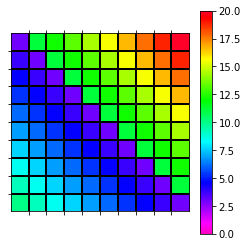

In [25]:
plt.close('all')
plt.matshow(T, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.yticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.grid(color='k', linewidth=2)
plt.show()

#### Toeplitz matrices are not diagonalized by the Fourier matrix

In [27]:
FN = dft(N, scale='sqrtn')

In [28]:
# DFT of the first column of T
DFT_first_column_T = np.sqrt(N)*np.dot(FN, T[:,0])

In [29]:
# create a diagonal matrix with the vector computed above
Diagonal_matrix = np.diag(DFT_first_column_T)

In [30]:
# create a matrix using the diagonal matrix computed above
T_prime = np.linalg.multi_dot([np.conjugate(FN), Diagonal_matrix, FN]).real

In [31]:
# compare the original Toepliz matrix T and that computed above
np.allclose(T, T_prime)

False

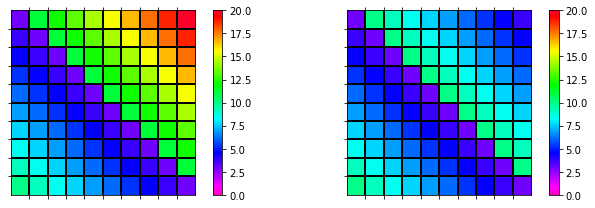

In [32]:
plt.close('all')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

plt.subplot(121)
plt.matshow(T, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.yticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(122)
plt.matshow(T_prime, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.yticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

Notice that only the lower triangle of these matrices are equal to each other.

In [33]:
np.allclose(np.tril(T), np.tril(T_prime))

True

#### We cannot compute the matrix-vector product by the Fourier transform

In [34]:
# create a vector w
w = np.random.rand(N)

In [35]:
# product of T and this vector w
Tw_matvec = np.dot(T, w)

In [36]:
# DFT of vector w
DFT_w = np.dot(FN, w)

In [37]:
# try to compute the Tw product by using the DFT of first column of T
Tw_approx = np.dot(np.conjugate(FN), DFT_first_column_T*DFT_w).real

In [38]:
# notice that they are not the same
np.allclose(Tw_matvec, Tw_approx)

False

In [39]:
print(Tw_matvec)

[86.63678697 73.74023318 62.95826454 57.42948463 50.62983613 49.2223143
 43.36082472 42.77616011 37.36614803 36.11443375]


In [40]:
print(Tw_approx)

[40.13200825 37.17401711 34.56952832 35.90126873 34.98244285 38.60908309
 37.06763887 39.77553964 36.654798   36.11443375]


But in some particular situations, we are still able to compute the product of the Toeplitz matrix and a vector by using the Fourier transform.

In [41]:
# order of matrix T
N = 10

# number of non-null elements in the first column of T
N1 = 4

# first column of T with only the first N1 elements different from zero
col_T = np.linspace(3, 20, N)
col_T[N1:] = 0

# the first row has all off-diagonal term equal to zero
row_T = np.zeros(N)

In [42]:
T = toeplitz(col_T, row_T)

In [43]:
# vector w with 
w = 17*np.random.rand(N) + 3
w[N-N1:] = 0

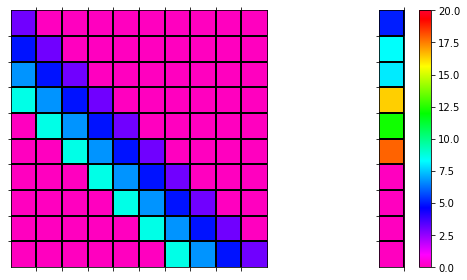

In [44]:
plt.figure(figsize=(7, 4))

plt.subplot(1,2,1)
plt.matshow(T, fignum=0, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
#plt.colorbar()
plt.xticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.yticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(1,2,2)
plt.matshow(np.reshape(w, (w.size,1)), fignum=0, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=[0.5], labels=[])
plt.yticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

In [45]:
FN = dft(N, scale='sqrtn')

In [46]:
# DFT of the first column of T
DFT_first_column_T = np.sqrt(N)*np.dot(FN, T[:,0])

In [47]:
# create a diagonal matrix with the vector computed above
Diagonal_matrix = np.diag(DFT_first_column_T)

In [48]:
# matrix computed with the diagonal matrix computed above
T_prime = np.linalg.multi_dot([np.conjugate(FN), Diagonal_matrix, FN]).real

In [49]:
# compare the original Toepliz matrix T and its approximated form
np.allclose(T, T_prime)

False

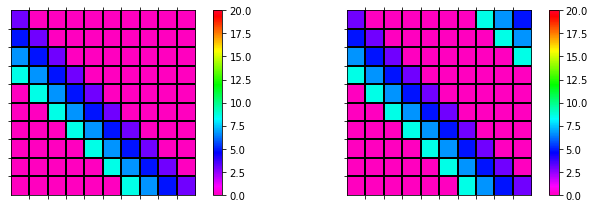

In [50]:
plt.close('all')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

plt.subplot(121)
plt.matshow(T, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.yticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(122)
plt.matshow(T_prime, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.yticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

Notice that, as in the previous case, only the lower triangle of these matrices are equal to each other.

In [51]:
np.allclose(np.tril(T), np.tril(T_prime))

True

There is something very special here. The differences between the Toeplitz matrix $\mathbf{T}$ (shown at left) and the approximating matrix $\mathbf{T}^{\prime}$ (shown at right) are concentrated at the upper right corner. Despite this corner, the matrices are equal to each other. Another important thing is that, when multiplied by the vector $\mathbf{w}$, this upper corner coincides with the last null elements of $\mathbf{w}$. As a consequence:

$$
\mathbf{T} \mathbf{w} = \mathbf{T}^{\prime} \mathbf{w}.
$$

In [52]:
Tw_matvec = np.dot(T, w)

In [53]:
DFT_w = np.dot(FN, w)

In [54]:
T_prime_w_matvec = np.dot(np.conjugate(FN), DFT_first_column_T*DFT_w).real

In [55]:
np.allclose(Tw_matvec, T_prime_w_matvec)

True

In [56]:
print(np.round(Tw_matvec, decimals=4))

[ 15.0724  49.5462  98.7237 188.0488 242.7677 293.4801 312.1099 227.4688
 155.7276   0.    ]


In [57]:
print(np.round(T_prime_w_matvec, decimals=4))

[ 15.0724  49.5462  98.7237 188.0488 242.7677 293.4801 312.1099 227.4688
 155.7276  -0.    ]


The cells above show that the product of a Toeplitz matrix $\mathbf{T}$ and a vector $\mathbf{w}$ can be computed by using the Fourier transform if:

* $\mathbf{T}$ is lower triangular
* the last N-N1 elements (with N1 < N) of $\mathbf{T}[: \, , \, 0]$ are equal to zero
* the last N1 elements (with N1 < N) of $\mathbf{w}$ are equal to zero

### Any $N \times N$ Toeplitz matrix can be embedded into a $2N \times 2N$ circulant matrix

Any Toeplitz matrix $\mathbf{T}$ can be embedded into a $2N \times 2N$ circulant matrix $\mathbf{C}$ with first column given by:

$$
\mathbf{c}_{0} = \begin{bmatrix}
t_{00} \\
t_{10} \\
\vdots \\
t_{(N-1)0} \\
0 \\
t_{0(N-1)} \\
t_{0(N-2)} \\
\vdots \\
t_{01}
\end{bmatrix} \: .
$$

Let consider $N = 4$. In this case, the Toeplitz matrix $\mathbf{T}$ and the embedding circulant matrix $\mathbf{C}$ are given by:

$$
\mathbf{T} = \begin{bmatrix}
t_{00} & t_{01} & t_{02} & t_{03} \\
t_{10} & t_{00} & t_{01} & t_{02} \\
t_{20} & t_{10} & t_{00} & t_{01} \\
t_{30} & t_{20} & t_{10} & t_{00} \\
\end{bmatrix}
$$

and

$$
\mathbf{C} = \begin{bmatrix}
t_{00} & t_{01} & t_{02} & t_{03} &      0 & t_{30} & t_{20} & t_{10} \\
t_{10} & t_{00} & t_{01} & t_{02} & t_{03} &      0 & t_{30} & t_{20} \\
t_{20} & t_{10} & t_{00} & t_{01} & t_{02} & t_{03} &      0 & t_{30} \\
t_{30} & t_{20} & t_{10} & t_{00} & t_{01} & t_{02} & t_{03} &      0 \\
     0 & t_{30} & t_{20} & t_{10} & t_{00} & t_{01} & t_{02} & t_{03} \\
t_{03} &      0 & t_{30} & t_{20} & t_{10} & t_{00} & t_{01} & t_{02} \\
t_{02} & t_{03} &      0 & t_{30} & t_{20} & t_{10} & t_{00} & t_{01} \\
t_{01} & t_{02} & t_{03} &      0 & t_{30} & t_{20} & t_{10} & t_{00}
\end{bmatrix} \quad .
$$

In [ ]:
N = 10
col_T = np.linspace(3, 12, N)
row_T = np.linspace(12, 20, N)

In [ ]:
T = toeplitz(col_T, row_T)

In [ ]:
C_embedding = circulant(c=np.hstack([T[:,0], 0, T[0,-1:0:-1]]))

In [ ]:
plt.close('all')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

plt.subplot(121)
plt.matshow(C_embedding, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=[N-0.5], labels=[])
plt.yticks(ticks=[N-0.5], labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(122)
plt.matshow(T, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.yticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

### Product of an arbitrary Toeplitz matrix $\mathbf{T}$ and an arbitrary vector $\mathbf{w}$

Let $\mathbf{w}$ be an arbitrary $N \times 1$ vector. The product of the $N \times N$ Toeplitz matrix $\mathbf{T}$ and vector $\mathbf{w}$ can be computed by first embedding $\mathbf{T}$ into a $2N \times 2N$ circulant matrix $\mathbf{C}$ according to the procedure defined above. Then, padd the vector $\mathbf{w}$ with $N$ zeros to create a new vector $\mathbf{v}$. 

$$
\begin{split}
\mathbf{T} &\Rightarrow \mathbf{C} \\
\mathbf{w} &\Rightarrow \mathbf{v}
\end{split}
$$

In [ ]:
N = 21
col_T = 10*np.random.rand(N)
row_T = 10*np.random.rand(N)

In [ ]:
T = toeplitz(col_T, row_T)

In [ ]:
w = np.random.rand(N)

In [ ]:
Tw_matvec = np.dot(T, w)

In [ ]:
C_embedding = circulant(c=np.hstack([T[:,0], 0, T[0,-1:0:-1]]))

In [ ]:
v_embedding = np.hstack([w, np.zeros(N)])

In [ ]:
F2N = dft(2*N, scale='sqrtn')

In [ ]:
DFT_v_embedding = np.dot(F2N, v_embedding)

In [ ]:
lambda_C_embedding = np.sqrt(2*N)*np.dot(F2N, C_embedding[:,0])

In [ ]:
C_v_embedding = np.dot(np.conjugate(F2N), lambda_C_embedding*DFT_v_embedding)

In [ ]:
np.allclose(Tw_matvec, C_v_embedding[:N])